1.Segmentaion

In [1]:
import numpy as np                          # For numerical operations like arrays, math, statistics
import tifffile as tiff                     # To read/write hyperspectral TIFF images
from skimage import filters                 # Image processing filters (Laplacian, Gaussian, etc.)
from skimage.filters import threshold_otsu  # Otsu thresholding for image segmentation
from sklearn.cluster import KMeans          # KMeans clustering algorithm
from ipywidgets import interact, IntSlider  # Interactive sliders for Jupyter Notebook
import matplotlib.pyplot as plt             # To plot images and graphs
from matplotlib import cm                   # Colormap utilities
from matplotlib.colors import ListedColormap # For custom colormaps in clustering visualization
from matplotlib.patches import Patch        # To create legend patches for clusters

# Define wavelength range (400–1000 nm, total 204 bands)
num_bands = 204                               # Total number of spectral bands in dataset
wavelength_start = 400                         # Start wavelength in nanometers
wavelength_end = 1000                          # End wavelength in nanometers
wavelengths = np.linspace(wavelength_start, wavelength_end, num_bands)  # Evenly spaced wavelengths for each band

# Function to calculate metrics for a single band
def calculate_band_metrics(band_array):
    # Normalize band values to range 0–1
    band_norm = (band_array - np.nanmin(band_array)) / (np.nanmax(band_array) - np.nanmin(band_array) + 1e-8)

    brightness = np.nanmean(band_norm)                 # Average intensity of the band
    contrast = np.nanstd(band_norm)                    # Contrast as standard deviation
    sharpness = filters.laplace(band_norm).var()      # Sharpness using Laplacian variance

    # High-frequency components for noise estimation
    highpass = band_norm - filters.gaussian(band_norm, sigma=1)  
    noise = np.nanstd(highpass)                        # Standard deviation of high-frequency signal = noise
    signal = np.sqrt(np.nanmean(band_norm**2))        # Signal power
    snr = 20 * np.log10(signal / (noise + 1e-8))      # Signal-to-noise ratio in dB

    # Return all metrics in a dictionary
    return {
        "Brightness": brightness,
        "Contrast": contrast,
        "Sharpness": sharpness,
        "SNR(dB)": snr
    }

# Interactive function for metrics, segmentation, clustering
def show_band_metrics_interactive(img_id, band_idx):
    # Construct file path for the image based on Image ID
    file_path = f"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/image/{img_id:05d}.tiff"

    try:
        cube = tiff.imread(file_path)            # Load hyperspectral cube (bands, rows, cols)
        bands, rows, cols = cube.shape           # Get cube dimensions

        # Print basic information about the image
        print(f"Loaded Image ID: {img_id}")
        print(f"Image width: {cols}, height: {rows}, bands: {bands}, dtype: {cube.dtype}")
        bit_depth = cube.dtype.itemsize * 8      # Calculate bit depth from data type
        print(f"Bit depth: {bit_depth}\n")

        cube = np.transpose(cube, (1, 2, 0))    # Rearrange cube to (rows, cols, bands) for visualization
        band_array = cube[:, :, band_idx]        # Extract the selected band

        metrics = calculate_band_metrics(band_array)  # Compute metrics for the band

        # Print band wavelength if available
        if len(wavelengths) == bands:
            band_wavelength = wavelengths[band_idx]
            print(f"Selected Band: {band_idx} | Wavelength: {band_wavelength:.2f} nm")
        else:
            print(f"Selected Band: {band_idx} | Wavelength info not available")

        # Print metrics
        print(f"Brightness: {metrics['Brightness']:.4f}")
        print(f"Contrast: {metrics['Contrast']:.4f}")
        print(f"Sharpness: {metrics['Sharpness']:.4f}")
        print(f"SNR(dB): {metrics['SNR(dB)']:.4f}")

        # Leaf segmentation using Otsu threshold
        thresh = threshold_otsu(band_array)      # Compute Otsu threshold
        mask = band_array > thresh                # Create binary mask of leaf area
        segmented_leaf = band_array * mask        # Apply mask to band for segmented leaf

        # KMeans clustering for disease detection
        n_clusters = 3
        if np.sum(mask) > 10:                     # Ensure there are enough pixels to cluster
            leaf_pixels_band = band_array[mask].reshape(-1, 1)  # Flatten leaf pixels
            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10).fit(leaf_pixels_band)  # Run KMeans
            disease_mask = np.zeros_like(band_array)             # Initialize cluster mask
            disease_mask[mask] = kmeans.labels_ + 1              # Assign cluster labels to leaf pixels
        else:
            disease_mask = np.zeros_like(band_array)            # If not enough pixels, empty mask
            kmeans = None

        # Extract leaf pixels for spectral analysis
        leaf_pixels_cube = cube[mask, :]          # Extract all bands for leaf pixels
        mean_spectrum = np.mean(leaf_pixels_cube, axis=0)  # Mean reflectance spectrum
        min_spectrum = np.min(leaf_pixels_cube, axis=0)    # Minimum reflectance
        std_spectrum = np.std(leaf_pixels_cube, axis=0)    # Standard deviation

        # Visualization (2x2 layout)
        fig, axes = plt.subplots(2, 2, figsize=(12, 4))  
        axes = axes.ravel()                         # Flatten axes array

        # RGB Composite creation using approximate R,G,B wavelengths
        def find_band_index(target_wl):
            return np.argmin(np.abs(wavelengths - target_wl))  # Find closest band to target wavelength

        r_idx = find_band_index(660)                 # Red band (~660 nm)
        g_idx = find_band_index(550)                 # Green band (~550 nm)
        b_idx = find_band_index(470)                 # Blue band (~470 nm)

        rgb_img = np.stack([cube[:, :, r_idx],
                            cube[:, :, g_idx],
                            cube[:, :, b_idx]], axis=-1)   # Combine 3 bands to RGB
        rgb_img = (rgb_img - np.min(rgb_img)) / (np.max(rgb_img) - np.min(rgb_img) + 1e-8)  # Normalize

        axes[0].imshow(rgb_img)                     # Show RGB image
        axes[0].set_title(f"Original Leaf ({img_id})")
        axes[0].axis("off")

        axes[1].imshow(mask, cmap='gray')           # Show Otsu binary mask
        axes[1].set_title("Otsu Binary Mask", fontsize=12)
        axes[1].axis("off")

        axes[2].imshow(segmented_leaf, cmap='gray') # Show segmented leaf
        axes[2].set_title("Segmented Leaf (Grayscale)", fontsize=12)
        axes[2].axis("off")

        cluster_cmap = ListedColormap(["black", "green", "orange", "blue"])  # Cluster colormap
        axes[3].imshow(disease_mask, cmap=cluster_cmap, vmin=0, vmax=3)     # Show clusters
        axes[3].set_title("Leaf Clusters (Healthy, Mild, Severe)", fontsize=12)
        axes[3].axis("off")

        legend_elements = [Patch(facecolor="green", edgecolor='k', label="Healthy"),
                           Patch(facecolor="orange", edgecolor='k', label="Mild Disease"),
                           Patch(facecolor="blue", edgecolor='k', label="Severe Disease")]
        axes[3].legend(handles=legend_elements, loc='upper right', fontsize=8)  # Add legend

        plt.tight_layout()
        plt.show()

        # Summary spectrum plot
        plt.figure(figsize=(9, 6))
        plt.plot(wavelengths, mean_spectrum, '-g', label="Mean Reflectance")   # Mean spectrum
        plt.plot(wavelengths, min_spectrum, '-r', label="Minimum Reflectance") # Min spectrum
        plt.plot(wavelengths, std_spectrum, '-b', label="Std Deviation")       # Std deviation

        # Highlight minimum reflectance point
        min_val = np.min(min_spectrum)
        min_idx = np.argmin(min_spectrum)
        min_wl = wavelengths[min_idx]
        plt.scatter(min_wl, min_val, color='red', zorder=5)
        plt.text(min_wl + 5, min_val, f"Min = {min_val:.4f} @ {min_wl:.1f} nm", color='red', fontsize=10, va='bottom')

        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Reflectance")
        plt.title(f"Summary Spectrum (Image ID {img_id})")
        plt.grid(True)
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
        plt.tight_layout()
        plt.show()

        # Cluster-wise spectra
        if kmeans is not None:
            cluster_names = ["Healthy", "Mild Disease", "Severe Disease"]
            cluster_colors = ["green", "orange", "blue"]

            plt.figure(figsize=(9, 6))
            for cluster_id in range(n_clusters):
                cluster_mask_pixels = (disease_mask == (cluster_id + 1))          # Mask for cluster
                if np.sum(cluster_mask_pixels) > 0:
                    cluster_pixels_cube = cube[cluster_mask_pixels, :]            # Extract cluster pixels
                    cluster_mean = np.mean(cluster_pixels_cube, axis=0)           # Mean spectrum
                    plt.plot(wavelengths, cluster_mean, label=f"{cluster_names[cluster_id]} Spectrum",
                             color=cluster_colors[cluster_id])
            plt.xlabel("Wavelength (nm)")
            plt.ylabel("Reflectance")
            plt.title(f"Cluster-wise Spectra (Image ID {img_id})")
            plt.grid(True)
            plt.legend()
            plt.show()

        # Individual ROI pixel spectra
        num_pixels = leaf_pixels_cube.shape[0]          # Number of pixels in ROI
        fig, ax = plt.subplots(figsize=(9, 6))
        for i in range(num_pixels):
            ax.plot(wavelengths, leaf_pixels_cube[i], color=cm.viridis(i / num_pixels), linewidth=1)

        # Add colorbar showing pixel index
        sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=0, vmax=num_pixels - 1))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label("Pixel Index (ROI)")

        ax.set_xlabel("Wavelength (nm)")
        ax.set_ylabel("Reflectance")
        ax.set_title(f"Spectral Curves of ROI Pixels (Image ID {img_id})")
        plt.show()

    except FileNotFoundError:
        print(f"File for Image ID {img_id} not found.")  # Handle missing file error

# Dataset info
min_id = 0
max_id = 2409
first_img_file = f"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/image/{min_id:05d}.tiff"
first_cube = tiff.imread(first_img_file)       # Load first image to get number of bands
total_bands = first_cube.shape[0]

# Interactive sliders for Image ID and Band selection
interact(
    show_band_metrics_interactive,
    img_id=IntSlider(min=min_id, max=max_id, step=1, value=min_id, description='Image ID'),
    band_idx=IntSlider(min=0, max=total_bands-1, step=1, value=0, description='Band')
)


interactive(children=(IntSlider(value=0, description='Image ID', max=2409), IntSlider(value=0, description='Ba…

<function __main__.show_band_metrics_interactive(img_id, band_idx)>

2.Exceptional Images

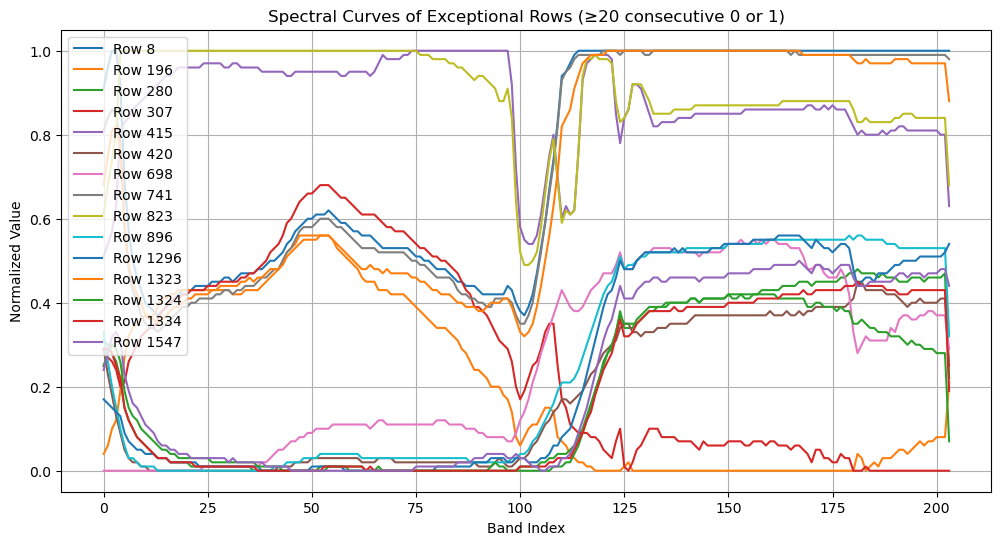

Total Exceptional Rows: 15
Exceptional Row Indexes: [8, 196, 280, 307, 415, 420, 698, 741, 823, 896, 1296, 1323, 1324, 1334, 1547]


In [2]:
import pandas as pd                       # pandas: for reading CSV files and data manipulation
import numpy as np                        # numpy: for numerical operations and arrays
import matplotlib.pyplot as plt           # matplotlib: for plotting data

# Step 1: Load dataset
file_path = r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/normalized_minmax_with_target_2.csv"
                                          # Full path to your CSV file (raw string so backslashes work)
df = pd.read_csv(file_path)               # Read the CSV file into a pandas DataFrame

# Drop target column if it exists
if 'Yield' in df.columns:
    feature_df = df.drop(columns=['Yield'])  # If 'Yield' column exists, drop it (keep only features)
else:
    feature_df = df                         # Otherwise, keep the whole DataFrame as features

num_bands = feature_df.shape[1]             # Number of spectral bands (columns) per row

# Step 2: Identify exceptional rows
min_run_length = 20                   # Condition: ≥25 consecutive values of 0 or 1
exceptional_rows = []                       # Empty list to store (row_index, row_data) of exceptional rows

# Loop over each row of the feature matrix
for idx, row in feature_df.iterrows():
    data = row.values.astype(float)         # Convert row into numpy array (float type)

    run_length = 1                          # Counter for length of consecutive sequence
    exceptional = False                     # Flag: will be True if this row is exceptional

    # Loop through the row values (start from index 1 to compare with previous element)
    for i in range(1, len(data)):
        # Only count if the value is exactly 0 or 1
        # and if it matches the previous value (consecutive repetition)
        if data[i] in [0, 1] and data[i] == data[i-1]:
            run_length += 1                 # Increase the consecutive run counter
            if run_length >= min_run_length:
                exceptional = True          # If the run is long enough, mark as exceptional
                break                       # Stop checking further in this row
        else:
            run_length = 1                  # Reset counter if values differ or not 0/1

    # After finishing the loop, if exceptional, save this row
    if exceptional:
        exceptional_rows.append((idx+2, data))  # Store tuple (row_index, row_data)

# Step 3: Plot exceptional rows with row index labels
if exceptional_rows:
    plt.figure(figsize=(12,6))             # Set figure size

    # Plot each exceptional row’s spectral curve
    for idx, data in exceptional_rows:
        plt.plot(range(len(data)), data, label=f'Row {idx}')  # Label with row index

    # Add title and axis labels
    plt.title(f"Spectral Curves of Exceptional Rows (≥{min_run_length} consecutive 0 or 1)")
    plt.xlabel("Band Index")                # x-axis = band number
    plt.ylabel("Normalized Value")          # y-axis = band value
    plt.grid(True)                          # Add grid for readability
    plt.legend()                            # Show legend (row indexes)
    plt.show()                              # Display the plot

    # Step 4: Print details
    print(f"Total Exceptional Rows: {len(exceptional_rows)}")  # Number of exceptional rows
    print("Exceptional Row Indexes:", [idx for idx, _ in exceptional_rows])  # Their indexes
else:
    print("No exceptional rows found!")     # If no exceptional row detected


In [ ]:
import numpy as np                     # For numerical operations (arrays, math)
import tifffile as tiff                # For reading/writing hyperspectral .tiff images
from skimage import filters            # For image processing (e.g., Laplacian, Gaussian)
from skimage.filters import threshold_otsu  # For automatic Otsu thresholding
from sklearn.cluster import KMeans     # KMeans clustering algorithm
from ipywidgets import interact, IntSlider, IntText  # Interactive widgets for Jupyter
import matplotlib.pyplot as plt        # Plotting library
from matplotlib.colors import ListedColormap  # For discrete cluster color maps
from matplotlib.patches import Patch  # For adding legend boxes

# Define wavelength range
num_bands = 204                        # Total number of spectral bands
wavelength_start = 400
wavelength_end = 1000
wavelengths = np.linspace(wavelength_start, wavelength_end, num_bands)  # Wavelength array

# Function to calculate band metrics
def calculate_band_metrics(band_array):
    band_norm = (band_array - np.nanmin(band_array)) / (np.nanmax(band_array) - np.nanmin(band_array) + 1e-8)
    
    brightness = np.nanmean(band_norm)
    contrast = np.nanstd(band_norm)
    sharpness = filters.laplace(band_norm).var()
    
    highpass = band_norm - filters.gaussian(band_norm, sigma=1)
    noise = np.nanstd(highpass)
    signal = np.sqrt(np.nanmean(band_norm**2))
    snr = 20 * np.log10(signal / (noise + 1e-8))
    
    return {"Brightness": brightness, "Contrast": contrast, "Sharpness": sharpness, "SNR(dB)": snr}

# Interactive function
def show_band_metrics_interactive(img_id, band_idx):
    file_path = f"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/image/{img_id:05d}.tiff"

    try:
        cube = tiff.imread(file_path)
        bands, rows, cols = cube.shape

        print(f"\nLoaded Image ID: {img_id}")
        print(f"Image width: {cols}, height: {rows}, bands: {bands}, dtype: {cube.dtype}")
        bit_depth = cube.dtype.itemsize * 8
        print(f"Bit depth: {bit_depth}\n")

        cube = np.transpose(cube, (1, 2, 0))
        band_array = cube[:, :, band_idx]

        metrics = calculate_band_metrics(band_array)
        if len(wavelengths) == bands:
            band_wavelength = wavelengths[band_idx]
            print(f"Selected Band: {band_idx} | Wavelength: {band_wavelength:.2f} nm")
        print(f"Brightness: {metrics['Brightness']:.4f}")
        print(f"Contrast: {metrics['Contrast']:.4f}")
        print(f"Sharpness: {metrics['Sharpness']:.4f}")
        print(f"SNR(dB): {metrics['SNR(dB)']:.4f}")

        # Otsu threshold segmentation
        thresh = threshold_otsu(band_array)
        mask = band_array > thresh
        segmented_leaf = band_array * mask

        # KMeans clustering
        n_clusters = 3
        disease_mask = np.zeros_like(band_array)
        if np.sum(mask) > 10:
            leaf_pixels_band = band_array[mask].reshape(-1, 1)
            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10).fit(leaf_pixels_band)
            disease_mask[mask] = kmeans.labels_ + 1

        # ===== Visualization (2x2 layout) =====
        fig, axes = plt.subplots(2, 2, figsize=(12, 4))
        axes = axes.ravel()

        # (0) RGB Composite
        def find_band_index(target_wl):
            return np.argmin(np.abs(wavelengths - target_wl))

        r_idx = find_band_index(660)
        g_idx = find_band_index(550)
        b_idx = find_band_index(470)

        rgb_img = np.stack([cube[:, :, r_idx],
                            cube[:, :, g_idx],
                            cube[:, :, b_idx]], axis=-1)
        rgb_img = (rgb_img - np.min(rgb_img)) / (np.max(rgb_img) - np.min(rgb_img) + 1e-8)

        axes[0].imshow(rgb_img)
        axes[0].set_title(f"Original Leaf ({img_id})")  # Added Image ID
        axes[0].axis("off")

        # (1) Otsu binary mask
        axes[1].imshow(mask, cmap='gray')
        axes[1].set_title("Otsu Binary Mask")
        axes[1].axis("off")

        # (2) Segmented leaf
        axes[2].imshow(segmented_leaf, cmap='gray')
        axes[2].set_title("Segmented Leaf (Grayscale)")
        axes[2].axis("off")

        # (3) Leaf clusters
        cluster_cmap = ListedColormap(["black", "green", "orange", "blue"])
        axes[3].imshow(disease_mask, cmap=cluster_cmap, vmin=0, vmax=3)
        axes[3].set_title("Leaf Clusters (Healthy, Mild, Severe)")
        axes[3].axis("off")

        # Cluster legend
        legend_elements = [
            Patch(facecolor="green", edgecolor='k', label="Healthy"),
            Patch(facecolor="orange", edgecolor='k', label="Mild Disease"),
            Patch(facecolor="blue", edgecolor='k', label="Severe Disease")
        ]
        axes[3].legend(handles=legend_elements, loc='upper right', fontsize=8)

        plt.tight_layout()
        plt.show()

    except FileNotFoundError:
        print(f"File for Image ID {img_id} not found.")

# Dataset info
min_id = 0
max_id = 2409
first_img_file = f"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/image/{min_id:05d}.tiff"
first_cube = tiff.imread(first_img_file)
total_bands = first_cube.shape[0]

# Interactive controls
interact(
    show_band_metrics_interactive,
    img_id=IntText(min=min_id, max=max_id, value=min_id, description='Image ID'),
    band_idx=IntSlider(min=0, max=total_bands-1, step=1, value=0, description='Band')
)


interactive(children=(IntText(value=0, description='Image ID'), IntSlider(value=0, description='Band', max=203…

<function __main__.show_band_metrics_interactive(img_id, band_idx)>

3.Image to xlsx

In [ ]:
# image to xlsx file convert
import numpy as np                     # For numerical operations
import tifffile as tiff                # To read hyperspectral .tiff images
from skimage.filters import threshold_otsu   # For automatic thresholding (segmentation)
import pandas as pd                    # To store and save tabular data (Excel)
import os                              # For file and directory handling

# Dataset info
data_dir = r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/image/"  
# Path to dataset folder containing hyperspectral images

all_files = sorted([f for f in os.listdir(data_dir) if f.endswith(".tiff")])  
# List all .tiff files in dataset, sorted by name (00000.tiff → 02409.tiff)

num_bands = 204                        # Number of spectral bands per image
wavelengths = np.linspace(400, 1000, num_bands)  
# Create wavelength array from 400–1000 nm (evenly spaced for 204 bands)

# Yield example (0–2409)
num_images = 2410                      # Total images in dataset
np.random.seed(42)                     # Fix random seed for reproducibility
yield_values = np.round(np.random.uniform(3.0, 5.0, size=num_images), 2)  
# Simulated yield values between 3.0–5.0 (2 decimal places)

yield_dict = {i: yield_values[i] for i in range(num_images)}  
# Map each image ID to a simulated yield value

# Function: Extract Metrics
def extract_metrics(file_path):
    cube = tiff.imread(file_path)             # Read hyperspectral cube (bands, rows, cols)
    cube = np.transpose(cube, (1, 2, 0))      # Rearrange to (rows, cols, bands)

    ref_band = cube[:, :, 50]                 # Select one reference band (index 50 ~ ~520nm)
    otsu_thresh = threshold_otsu(ref_band)    # Compute Otsu threshold for segmentation
    mask = ref_band > otsu_thresh             # Binary mask (leaf pixels = True)

    leaf_pixels = cube[mask, :]               # Extract spectra of only leaf pixels
    mean_spectrum = np.mean(leaf_pixels, axis=0)  # Average reflectance across bands
    min_reflectance = np.min(leaf_pixels)     # Minimum reflectance value (for health check)

    return mean_spectrum, min_reflectance, otsu_thresh  
    # Return metrics for further processing

# Collect Data
records = []                                  # Empty list to store all rows

for file_name in all_files:                   # Loop through every TIFF image
    try:
        img_id = int(file_name.split(".")[0]) # Extract numeric ID from filename
        file_path = os.path.join(data_dir, file_name)  # Build full file path

        mean_spec, min_ref, otsu_val = extract_metrics(file_path)  
        # Extract spectrum, min reflectance & Otsu threshold for this image

        yield_val = yield_dict.get(img_id, np.nan)  
        # Get yield value for this image ID (or NaN if missing)

        # Clear & readable column names
        record = {"Image ID": img_id}         # Start with image ID
        for i, wl in enumerate(wavelengths):  # Loop through all bands
            record[f"{int(wl)} nm"] = mean_spec[i]  
            # Save mean reflectance for each wavelength (e.g., "400 nm", "405 nm"...)

        # Right-most metrics
        record["Minimum Reflectance"] = min_ref   # Store min reflectance value
        record["Otsu Threshold"] = otsu_val       # Store segmentation threshold
        record["Yield"] = yield_val               # Store corresponding yield

        records.append(record)                    # Add this record (row) to list

    except FileNotFoundError:                     # If file not found → skip
        print(f"Image {file_name} not found, skipping...")

# Save to Excel
df = pd.DataFrame(records)                        # Convert all records into DataFrame
output_file = "hyperspectral.xlsx"  # Output Excel file name
df.to_excel(output_file, index=False)             # Save DataFrame to Excel (no row index)

print(f"✅ Excel saved with clean headers: {output_file}")  
# Confirmation message
